In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import iris.analysis.maths as imath
from iris.pandas import as_data_frame
import esem

import numpy as np
import pandas as pd
# from eofs.iris import Eof

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4


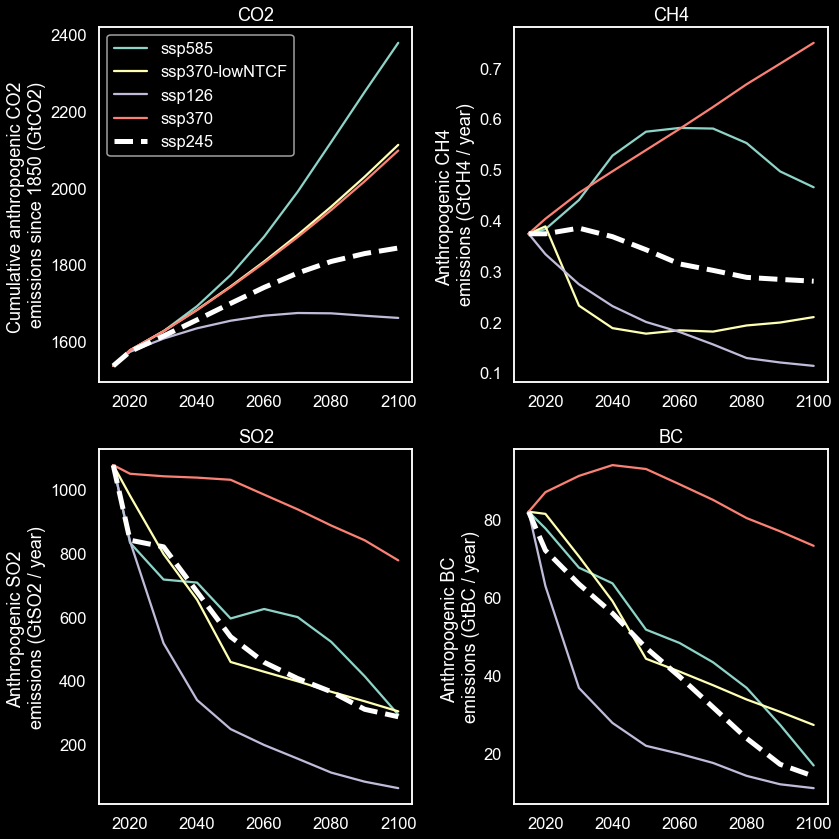

In [46]:
from glob import glob
import seaborn as sns
AREA_OF_EARTH = 5.101e+14 #m2
SECONDS_IN_YEAR = 60*60*24*365 #s
MASS_OF_CARBON = 1.9944235e-26  #kg
FRACTION_OF_CARBON_MASS = (6) / (6 + 8 + 8)

convert = lambda x: x * AREA_OF_EARTH * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

# Only future scenarios for now
inputs = glob("/Users/watson-parris/Local Data/ClimateBench/inputs_s*.nc")

with sns.plotting_context("talk"):
#     sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")

#     sns.set_style('dark')
    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    for input in inputs:
        label=input.split('_')[1][:-3]
        X = iris.load(input)
        x = range(2015, 2101)
        
        # TODO: It looks like the SSP future concentrations of CO2 are wrong compared to 
#         https://www.nature.com/articles/ngeo3031/figures/1
# and https://gmd.copernicus.org/articles/9/3461/2016/gmd-9-3461-2016.pdf Figure 3
#  I probably just need to multiply by 3.667 (but only for the future emissions)
#         axes[0, 0].plot(x, np.gradient(X.extract_cube('CO2').data), label=label)
        kwargs = {}
        if label == "ssp245":
            kwargs['color'] = 'white'
            kwargs['ls'] = '--'
            kwargs['lw'] = '5'
        axes[0, 0].plot(x, X.extract_cube('CO2').data, label=label, **kwargs)
        axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
        axes[0, 1].plot(x, X.extract_cube('CH4').data, label=label, **kwargs)
        axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
#         TODO: These both appear to be out by a factor of 10... Maybe to do with the weighting??
# See e.g. https://acp.copernicus.org/preprints/acp-2019-1211/acp-2019-1211.pdf
        axes[1, 0].plot(x, convert(X.extract_cube('SO2').collapsed(['latitude', 'longitude'], iris.analysis.SUM).data), label=label, **kwargs)
        axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
        axes[1, 1].plot(x, convert(X.extract_cube('BC').collapsed(['latitude', 'longitude'], iris.analysis.SUM).data), label=label, **kwargs)
        axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

    axes[0, 0].set_title('CO2')
    axes[0, 1].set_title('CH4')
    axes[1, 0].set_title('SO2')
    axes[1, 1].set_title('BC')
    axes[0, 0].legend()
    plt.tight_layout()

In [3]:
from iris.cube import CubeList
# Get one combined historical + ssp585 timeseries for now
X = (iris.load('inputs_historical.nc') + iris.load('inputs_ssp585.nc')).concatenate()
# Just take the 1st ensemble member for this scenario
Y = CubeList([c[0] for c in iris.load('outputs_historical.nc') + iris.load('outputs_ssp585.nc')]).concatenate()


In [4]:
# Get the test data (NOT visible to contestants)

test_Y = iris.load('outputs_ssp245.nc')
test_X = iris.load('inputs_ssp245.nc')


In [7]:
from ipywidgets import IntSlider, interact

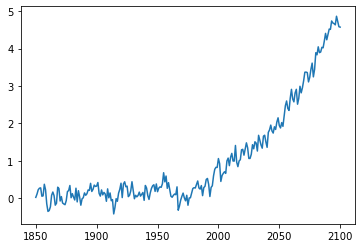

In [8]:
iplt.plot(Y.extract_cube("tas").collapsed(['lat','lon'], iris.analysis.MEAN))

In [9]:
def func(i):
    ax = plt.axes(projection=ccrs.PlateCarree())
    iplt.pcolormesh(Y.extract_cube("tas").extract(iris.Constraint(time=i)), vmin=-2, vmax=2, cmap='RdBu_r')
    ax.coastlines()
    plt.colorbar()
    plt.show()
    
interact(func,i=IntSlider(min=1850, max=2014, step=1, continuous_update=False));

interactive(children=(IntSlider(value=1850, continuous_update=False, description='i', max=2014, min=1850), Out…